### Bitcoin LSTM Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

os.chdir('C:/Users/gerar/OneDrive/Documentos/GitHub/bitcoinPred')  # Set the working directory

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X, y: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Scale the features to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Main execution block
file_path = "data/processed/btc_lstm.csv"  # Path to the LSTM-ready dataset
sequence_length = 30  # Number of time steps in each sequence

try:
    # Load and prepare the data
    X, y, scaler = load_and_prepare_data(file_path, sequence_length)

    # Split the data into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Train the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

    print("Model training complete!")

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.5151e-04 - val_loss: 0.0054
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 8.8214e-04 - val_loss: 0.0049
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.8320e-04 - val_loss: 0.0013
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.5597e-04 - val_loss: 0.0010
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.8848e-04 - val_loss: 0.0019
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.7285e-04 - val_loss: 0.0067
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 7.3378e-04 - val_loss: 0.0016
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms

### Model Evaluation
#### Calculate metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the validation set.

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Inverse transform the predictions and actual values to the original scale
y_val_pred_original = scaler.inverse_transform(np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1))[:, 0]
y_val_original = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1))[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(y_val_original, y_val_pred_original)
rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Mean Absolute Error (MAE): 2655.12
Root Mean Squared Error (RMSE): 3268.37


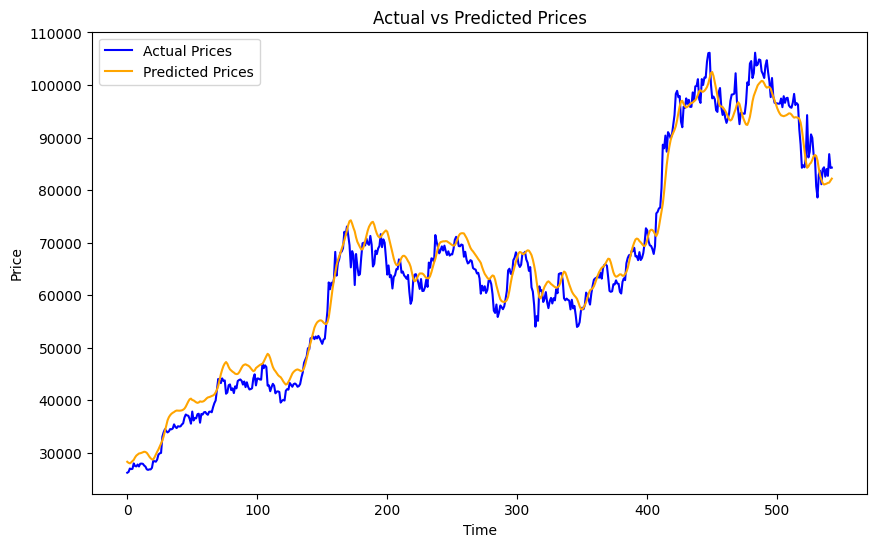

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="Actual Prices", color="blue")
plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model, history = train_lstm_model(X_train, y_train, X_test, y_test, input_shape)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_test_pred_original = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((y_test_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0085 - val_loss: 0.0043
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.4306e-04 - val_loss: 0.0013
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.2425e-04 - val_loss: 0.0027
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.1501e-04 - val_loss: 0.0063
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 7.3286e-04 - val_loss: 0.0073
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.0929e-04 - val_loss: 9.8696e-04
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 8.0068e-04 - val_loss: 0.0032
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.8446e-04 - val_loss: 0.0015
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.5889e-04 - val_loss: 0.0026
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━

In [11]:
# Use the last 7 rows for training and the next row for testing
X_train, y_train = X[-8:-1], y[-8:-1]  # Last 7 rows
X_test, y_test = X[-1:], y[-1:]        # Current day (last row)

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model, history = train_lstm_model(X_train, y_train, X_test, y_test, input_shape)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_test_pred_original = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((y_test_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

print(f"Actual Price: {y_test_original[0]:.2f}")
print(f"Predicted Price: {y_test_pred_original[0]:.2f}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3394 - val_loss: 0.0269
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0443 - val_loss: 0.0677
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0741 - val_loss: 0.1042
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1229 - val_loss: 0.0442
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0349 - val_loss: 0.0052
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0524 - val_loss: 0.0062
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0287 - val_loss: 0.0309
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0278 - val_loss: 0.0495
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0404 - val_loss: 0.0529
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0347 - val_loss: 0.0451
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Actual Price: 84280.04
Predicted Price: 91695.62
